# KNN model


### 1a. Import dependencies for data manipulation and visualization

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#### Import data

In [337]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

#### Establish inputs and output columns.

In [386]:
x = df.drop('energy', axis=1)
y = df['energy']


### Now I want to look at the data and do some cleanup if we have any outliers that might skew evaluation of the model.

mean:  16872466.03287671
median:  16957050.0


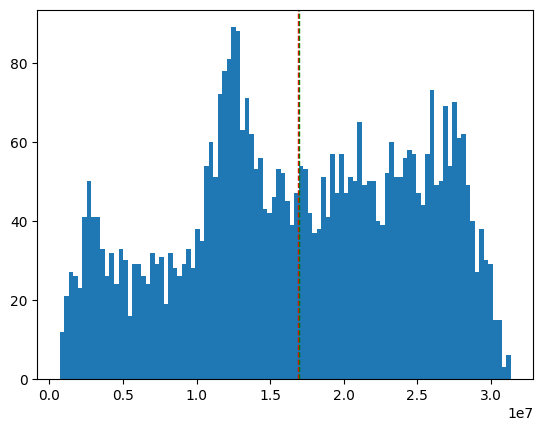

lower bound:  -7178400.0
upper bound:  42307800.0
number of outliers:  0


In [404]:
# plot the y values to see the distribution and check for outliers

plt.hist(y, bins=100)

plt.axvline(y.mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(y.median(), color='g', linestyle='dashed', linewidth=1)

print('mean: ', y.mean())
print('median: ', y.median())

plt.show()

# Even though the distribution is skewed, there don't appear to be any outliers, but let's check anyway

# Identify the outliers using the IQR method

q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (1.5*iqr)

print('lower bound: ', lower_bound)
print('upper bound: ', upper_bound)

# Identify the number of outliers

print('number of outliers: ', len(y[y > upper_bound]) + len(y[y < lower_bound]))











##### Since the number of outliers is 0, we can proceed with the model.

#### Import sklearn dependencies for standardization and train/test split.

In [339]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


#### Standardize the data and scale it for easier processing.

In [340]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



# Now do Holdout Method
#### We will use holdout at first to get a baseline accuracy score and show improvements with cross validation and hyperparameter tuning.

Split the data into training and testing sets.

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Import model from sci-kit learn and fit the data and then predict the output.

In [342]:
from sklearn.neighbors import KNeighborsRegressor

In [343]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [344]:
y_pred = knn.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [345]:
from sklearn.dummy import DummyRegressor

In [346]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

### Import dependencies for evaluation metrics and calculate mean squared error, r2 score, mean absolute error.

In [347]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


In [363]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  11794574247976.213
The dummy's mse:  64233127139167.26
Relative error:  0.18362136133310358


In [364]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)


The model's r2:  0.8157998956869279
The dummy's r2:  -0.0031518281738402987


In [365]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  2463576.7153471094
The dummy's mae:  6804090.003878151
Relative error:  0.36207291701652033


#### Now I want to visualize these scores and determine how we'll compare it to other more sophisticated models.

In [402]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y_test: {(mse**(1/2))/np.mean(y_test):.3f}")
    
 



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       11794574247976.213   64233127139167.258   0.184     
R2                        0.816                -0.003               -258.834  
MAE                       2463576.715          6804090.004          0.362     
Ratio of mae over mean value of y_test: 0.208


##### Looking at these scores, we can 

# That was the Holdout Method, now do K-Fold Cross Validation

Pt.2 Hyper parameter tuning with cross validation

In [352]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score


scores = cross_val_score(knn, X, y, cv=5)
print(scores)
print(scores.mean())


# Define the search space

param_grid = {
    'n_neighbors': list(range(1, 50)),
}

# Define the cross validation scheme.

cv = KFold(n_splits=5, shuffle=True, random_state=56)

better_knn = GridSearchCV(knn, param_grid, cv=cv, n_jobs=-1)

# print out the best score and parameters



scores = cross_val_score(better_knn, X, y, cv=cv)
print(scores)
print(scores.mean())

better_knn.fit(X, y) 
print(better_knn.best_params_)
print(better_knn.best_score_)


[0.74456232 0.78240433 0.81307038 0.79727357 0.73347094]
0.7741563084938978


[0.8023157  0.83772604 0.84144952 0.81327229 0.79993167]
0.8189390416519021
{'n_neighbors': 19}
0.8211663299283527


In [353]:
import matplotlib.pyplot as plt

prediction_scores = {}
n_neighbors = np.arange(2, 60, 1)

for neighbors in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    prediction_scores[neighbors] = mean_absolute_error(y_test, y_pred)/mae_dummy
    

Plot the scores

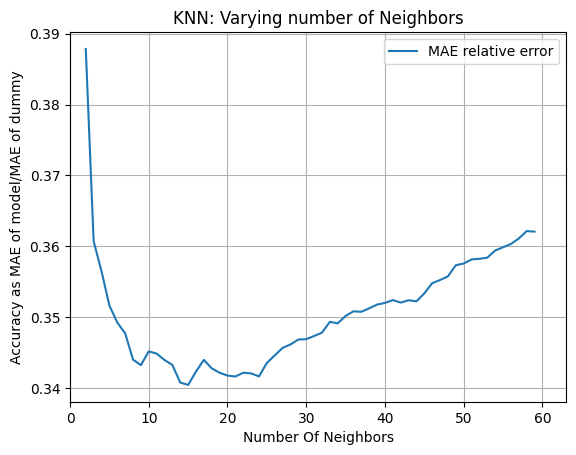

In [354]:
plt.plot(n_neighbors, prediction_scores.values(), label="MAE relative error")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy as MAE of model/MAE of dummy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, 63)
plt.grid()
plt.show()
